In [1]:
!pip install mediapipe opencv-python

  Using cached mediapipe-0.10.31-py3-none-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.31-py3-none-manylinux_2_28_x86_64.whl (10.3 MB)


In [2]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.15

Found existing installation: mediapipe 0.10.31
Uninstalling mediapipe-0.10.31:
  Successfully uninstalled mediapipe-0.10.31
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 861.0 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: 

In [1]:
import mediapipe as mp
print("MediaPipe version:", mp.__version__)
print("Has solutions:", hasattr(mp, "solutions"))


MediaPipe version: 0.10.15
Has solutions: True


In [2]:
import cv2
import mediapipe as mp
import numpy as np

In [3]:
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils

pose = mp_pose.Pose(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


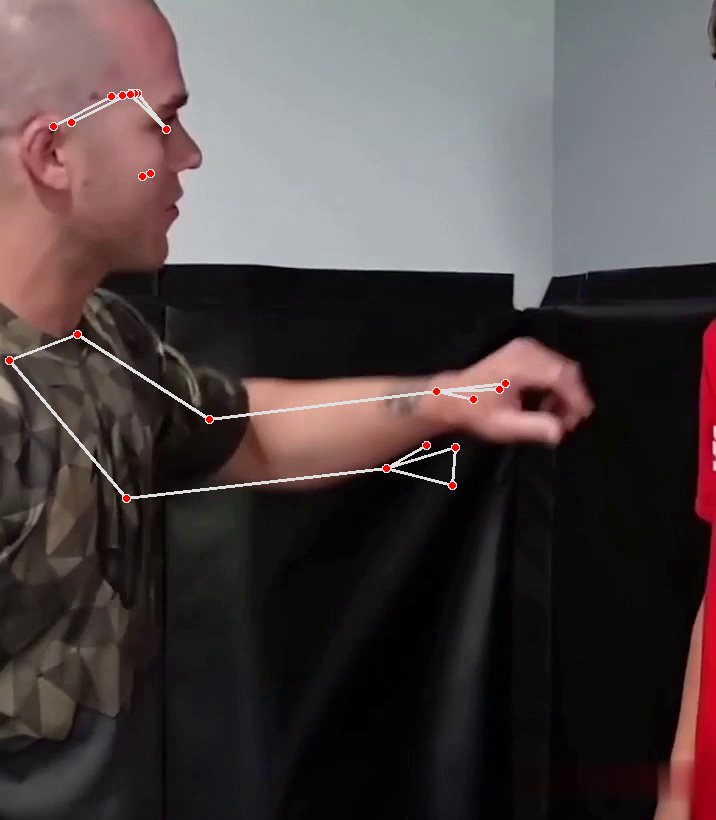

In [11]:
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture("/content/test_video.mp4")
ret, frame = cap.read()
cap.release()

if not ret:
    print("Failed to read video frame")
else:
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        mp_draw.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS
        )
        cv2_imshow(frame)
    else:
        print("No pose detected")


In [12]:
if results.pose_landmarks:
    landmarks = results.pose_landmarks.landmark

    right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]
    right_elbow = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]

    rw = np.array([right_wrist.x, right_wrist.y])
    re = np.array([right_elbow.x, right_elbow.y])
    rs = np.array([right_shoulder.x, right_shoulder.y])

    print("Right wrist:", rw)
    print("Right elbow:", re)
    print("Right shoulder:", rs)


Right wrist: [0.5395081  0.57171077]
Right elbow: [0.17720075 0.60794467]
Right shoulder: [0.0133438  0.43988585]


In [13]:
def calculate_angle(a, b, c):
    ba = a - b
    bc = c - b
    cosine = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(cosine))
    return angle

arm_angle = calculate_angle(rs, re, rw)
print("Right arm angle:", arm_angle)


Right arm angle: 128.56361879279817


In [14]:
cap = cv2.VideoCapture("/content/test_video.mp4")
prev_wrist = None
speeds = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        wrist = results.pose_landmarks.landmark[
            mp_pose.PoseLandmark.RIGHT_WRIST
        ]
        current = np.array([wrist.x, wrist.y])

        if prev_wrist is not None:
            speed = np.linalg.norm(current - prev_wrist)
            speeds.append(speed)

        prev_wrist = current

cap.release()

if speeds:
    print("Average hand speed:", np.mean(speeds))
else:
    print("No movement detected")


Average hand speed: 0.07943505211552868


In [15]:
import pandas as pd

data = {
    "arm_angle": [arm_angle],
    "hand_speed": [np.mean(speeds)]
}

df = pd.DataFrame(data)
df.to_csv("pose_features.csv", index=False)

print("Features saved for ANN training")


Features saved for ANN training
